In [12]:
from scipy.linalg import expm
from scipy.integrate import quad
from scipy.special import factorial
from scipy.interpolate import PPoly
from scipy.stats import sem
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import msprime as msp
import stdpopsim

In [13]:
%matplotlib inline
matplotlib.rcParams.update({
    'font.family': 'Times New Roman',
    'text.usetex': True,
})
import matplotlib.pyplot as plt

In [110]:
folder = '../../../exact_decoding_paper/figures/prior/'

## Exact SMC Simulations
### Simulation 1: Comparing renewal prior with Markov prior

#### Define necessary functions for simulations

In [14]:
def get_expected_coal_times(times, eta):
    r = eta[:-1]
    a = times[:-1]
    b = times[1:]
    dt = b - a
    # the exact formula is numerically unstable for small r, so use a taylor expansion.
    r_small = (a + b) / 2. - dt ** 2 * r / 12
    r_normal = b + 1. / r + dt / (np.expm1(-r * dt))
    ary = np.where(r * dt < 1e-4, r_small, r_normal)
    ret = np.concatenate([ary, times[None, -1] + 1 / eta[-1:]])
    return ret

def get_emissions(ts, w, L_w, mu, ect, w_end = None):
    site_locations = [int(v.position)//w for v in ts.variants()]
    loc, y = np.unique(site_locations, return_counts=True)
    
    if w_end is not None:
        counts = np.zeros(L_w)
        not_last = np.repeat(2 * mu * w, L_w - 1)
        rate = np.r_[not_last, 2 * mu * w_end]
        outer = np.outer(rate, ect)
        
    else:
        counts = np.zeros(L_w)
        rate = 2 * mu * w
        outer = rate * ect[None,:]
    
    counts[loc] = y
    
    emissions = (outer ** counts[:,None]) * np.exp(-outer)/factorial(counts)[:,None]
    return emissions

def initial_distribution(times, eta):
    x = np.r_[times, float('inf')]
    y = PPoly(eta[None,:],x)
    Y = y.antiderivative()
    cdf_vals = 1 - np.exp(-np.r_[Y(times), float('inf')])
    dist = cdf_vals[1:] - cdf_vals[:-1]
    return dist

def stationary_distribution(times, eta):
    N0 = 1/eta[0]
    vt = eta * N0
    times_scaled = times / N0
    x = np.r_[times_scaled, float('inf')]
    y = PPoly(vt[None,:],x)
    Y = y.antiderivative()
    
    def exp_int(tau):
        return np.exp(-Y(tau))
        
    denominator = quad(exp_int, 0, float('inf'))[0]
    def pi(t):
        return (t * y(t) * exp_int(t))/denominator
    
    vals = np.r_[Y(times), float('inf')]
    cdf_vals = np.r_[np.array([quad(pi, 0 ,t)[0] for t in times_scaled]), 1]
    dist = cdf_vals[1:] - cdf_vals[:-1]
    return dist

def get_transitions_Markov(times, rho, eta):
    x = np.r_[times, float('inf')]
    y = PPoly(eta[None,:],x)
    Y = y.antiderivative()
    
    A_rho = np.zeros((4,4))
    A_rho[0] = [-1, 1, 0, 0]
    A_rho[1] = [0, -0.5, 0.5, 0]
    A_eta = np.zeros((4,4))
    A_eta[1] = [1, -2, 0, 1]
    A_eta[2] = [0, 4, -5, 1]
    
    def q(t, s):
        if t > s:
            e_j = expm(times[s]*rho*A_rho + Y(times[s])*A_eta)
            return (e_j[0,1] + e_j[0,2]) * np.exp(-(Y(times[t-1])-Y(times[s]))) * (1-np.exp(-(Y(times[t])-Y(times[t-1]))))
        
        else:        
            e_k1 = expm(times[t]*rho*A_rho + Y(times[t])*A_eta)
            e_k2 = expm(times[t-1]*rho*A_rho + Y(times[t-1])*A_eta)

            if t < s:
                return e_k1[0,3] - e_k2[0,3]

            else:
                e_k3 = expm((times[t] - times[t-1])*rho*A_rho + (Y(times[t]) - Y(times[t-1]))*A_eta)

                p = e_k1[0,0]
                for i in range(3):
                    p += e_k2[0,i] * e_k3[i,3]
                return p
        
    transitions = np.empty((T,T))
    for i in range(1,T+1):
        for j in range(1,T+1):
            if j < T:
                transitions[i-1,j-1] = q(j,i)
            else:
                transitions[i-1,j-1] = np.max([1 - transitions[i-1,:j-1].sum(), 0])
    return np.maximum(transitions, 0)

def get_transitions_Renewal(times, ect, rho, eta):
#     rows = stationary_distribution(times, eta)
    rows = initial_distribution(times, eta)
    cols = -np.expm1(-rho*ect)
    diag = np.exp(-rho*ect)
    transitions = np.outer(cols, rows) + np.diag(diag)
    return transitions

def forward(L_w, T, init_dist, emissions, transitions):
    alpha = np.empty((L_w, T))
    alpha[0] = init_dist * emissions[0]
    c = np.empty(L_w)
    c[0] = alpha[0].sum()
    alpha[0] /= c[0]

    for i in range(1, L_w):
        alpha[i] = emissions[i] * (alpha[i-1][:,None] * transitions).sum(axis=0)
        c[i] = alpha[i].sum()
        alpha[i] /= c[i]
    return alpha, c

def backward(L_w, T, emissions, transitions, c):
    beta = np.empty((L_w, T))
    beta[-1] = np.ones(T)

    for i in range(L_w-2, -1, -1):
        beta[i] = (beta[i+1] * emissions[i+1,:] * transitions).sum(axis=1)
        beta[i] /= c[i+1]
    
    return beta
        
def get_posterior(L_w, T, init_dist, emissions, transitions):
    alpha, c = forward(L_w, T, init_dist, emissions, transitions)
    beta = backward(L_w, T, emissions, transitions, c)
    return np.maximum(alpha * beta,0)

def get_viterbi(log_T, log_B, log_pi, L):
    K = len(log_pi)
    T1 = np.zeros([L, K])
    T2 = np.zeros([L, K], dtype=int)
    T1[0] = log_pi + log_B[0] 
    for i in range(1,L):
        prob = T1[i-1][:,None] + log_T + log_B[i]
        T1[i] = np.max(prob, axis=0)
        T2[i] = np.argmax(prob, axis=0)
    
    Z = np.zeros(L, dtype=int)
    Z[L-1] = np.argmax(T1[L-1])
    
    for i in range(L - 1, 0, -1):
        Z[i - 1] = T2[i, Z[i]]
    return Z

def run_sim(num_sim, N0, mu, r, n, L, w, times, eta, rho, de=None):
    L_w = L // w
    T = times.size
    
    gammas_Markov = np.empty((num_sim, L_w, T))
    gammas_Renewal = np.empty((num_sim, L_w, T))
    viterbis_Markov = np.empty((num_sim, L_w), dtype=int)
    viterbis_Renewal = np.empty((num_sim, L_w), dtype=int)
    tss = []
    
    init_dist = initial_distribution(times, eta)
    ect = get_expected_coal_times(times, eta)
    transitions_Markov = get_transitions_Markov(times, rho, eta)
    transitions_Renewal = get_transitions_Renewal(times, ect, rho, eta)
    
    for i in range(num_sim):
        seed = i+1
        ts = msp.simulate(Ne=N0, 
                          mutation_rate=mu, 
                          recombination_rate=r, 
                          sample_size=n, 
                          length=L,
                          random_seed=seed,
                          demographic_events=de)
        tss.append(ts)

        emissions = get_emissions(ts, w, L_w, mu, ect)


        gammas_Markov[i] = get_posterior(L_w, T, init_dist, emissions, transitions_Markov)
        gammas_Renewal[i] = get_posterior(L_w, T, init_dist, emissions, transitions_Renewal)
        viterbis_Markov[i] = get_viterbi(np.log(transitions_Markov), np.log(emissions), np.log(init_dist), L_w)
        viterbis_Renewal[i] = get_viterbi(np.log(transitions_Renewal), np.log(emissions), np.log(init_dist), L_w)
        
    return gammas_Markov, gammas_Renewal, viterbis_Markov, viterbis_Renewal, tss, ect
    

#### Functions to plot results

In [15]:
def plot_viterbi(viterbis_Markov, viterbis_renewal, tss, seed, ects, L, w, rs, name):
    size = 25
    L_w = L // w
    scale_to_kb = 1000 / w
    
    fig, axs = plt.subplots(4, figsize=(20, 21), sharey=True)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    plot_labels = [r'Constant, Low $\rho$', r'Expansion, Low $\rho$', 
                   r'Constant, High $\rho$', r'Expansion, High $\rho$']
    
    for i, ax in enumerate(axs):
        ts = tss[i][seed]
        ect = ects[i]
        
        pmap = viterbis_Markov[i][seed]
        dpmap, = np.diff(pmap).nonzero()
        x = np.r_[0, dpmap, L_w - 1]
        y = ect[pmap[x]]
        ax.plot(x / scale_to_kb, y, drawstyle="steps-pre", color="green", label='Markov')

        pmap = viterbis_Renewal[i][seed]
        dpmap, = np.diff(pmap).nonzero()
        x = np.r_[0, dpmap, L_w - 1]
        y = ect[pmap[x]]
        ax.plot(x / scale_to_kb, y, drawstyle="steps-pre", color="blue", label='Renewal')


        truth = [(tree.interval[0] / w, tree.get_tmrca(0, 1)) for tree in ts.trees()]
        x, y = zip(*truth)
        x = np.r_[x, L_w]
        y = np.r_[y, y[-1]]
        ax.plot(x / scale_to_kb, y, drawstyle="steps-post", color="red", label='Truth')
        
        ax.set_yscale("log")
        ax.xaxis.set_tick_params(labelsize=size)
        ax.yaxis.set_tick_params(labelsize=size)
        ax.legend(loc = 'lower right', prop={'size': size})
        
        ax.text(0.01, .99, plot_labels[i], transform=ax.transAxes,
                fontsize=size, va='top')
        
        if i < 2:
            ax.set_xlim(0, L_w / scale_to_kb)
        else:
            ax.set_xlim(0, L_w / scale_to_kb * ratio)
            
        sns.despine()
        
        if i == 0:
            ymin = np.amin(y)
            ymax = np.amax(y)
        
        else:
            ylow = np.amin(y)
            if ylow < ymin:
                ymin = ylow
            
            yhigh = np.amax(y)
            if yhigh > ymax:
                ymax = yhigh
    
    plt.setp(ax.get_xticklabels(), fontsize=size)   
    plt.setp(ax.get_yticklabels(), fontsize=size)
    plt.setp(ax, ylim=(0.75 * ymin, 1.25 * ymax))
    
    plt.xlabel('Position (kb)', fontsize=size, labelpad = size)
    plt.ylabel('Coalescence time (Generations)', fontsize=size, labelpad = size)
    plt.tight_layout()
    plt.savefig(folder + name, bbox_inches='tight')
    plt.show()
    
def plot_posterior(gammas_Markov, gammas_Renewal, tss, seed, ects, L, w, ratio, name):
    size = 25
    L_w = L // w
    scale_to_kb = 1000 / w
    
    fig, axs = plt.subplots(8, figsize=(20, 28), sharey=True)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    plot_labels = [r'Constant, Low $\rho$', r'Expansion, Low $\rho$', 
                   r'Constant, High $\rho$', r'Expansion, High $\rho$']
    
    for i, ax in enumerate(axs):
        if i % 2 == 0:
            gamma = gammas_Markov[i//2][seed]
            ax.text(0.01, .99, plot_labels[i//2], transform=ax.transAxes,
                fontsize=size, va='top')
            
        else:
            gamma = gammas_Renewal[i//2][seed]
            
        ts = tss[i//2][seed]
        ect = ects[i//2]
        
        truth = [(tree.interval[0] / w, tree.get_tmrca(0, 1)) for tree in ts.trees()]
        x, y = zip(*truth)
        x = np.r_[x, L_w]
        y = np.r_[y, y[-1]]
        ax.plot(x / scale_to_kb, y, drawstyle="steps-post", color="red", label='Truth')
        
        X, Y = np.meshgrid(np.arange(L_w), ect)
        ax.pcolormesh(X / scale_to_kb, Y, gamma.T, cmap="Greys", rasterized=True)
        
        if i//2 < 2:
            ax.set_xlim(0, L_w / scale_to_kb)
        else:
            ax.set_xlim(0, L_w / scale_to_kb * ratio)
        
        ax.set_yscale("log")
        ax.xaxis.set_tick_params(labelsize=size)
        ax.yaxis.set_tick_params(labelsize=size)
        
        sns.despine()
        
        if i == 0:
            ymin = np.amin(y)
            ymax = np.amax(y)
        
        else:
            ylow = np.amin(y)
            if ylow < ymin:
                ymin = ylow
            
            yhigh = np.amax(y)
            if yhigh > ymax:
                ymax = yhigh
    
    plt.setp(ax.get_xticklabels(), fontsize=size)
    plt.setp(ax.get_yticklabels(), fontsize=size)
    plt.setp(ax, ylim=(0.75 * ymin, 1.25 * ymax))
    
    plt.xlabel('Position (kb)', fontsize=size, labelpad = size)
    plt.ylabel('Coalescence time (Generations)', fontsize=size, labelpad = size)
    plt.tight_layout()
    plt.savefig(folder + name, bbox_inches='tight')
    plt.show()
        

#### Functions to create tables

In [16]:
def get_truth(tss, w, times):
    T = times.size
    num_sim = len(tss) 
    L = tss[0].sequence_length
    L_w = int(L // w)
    truth = np.empty((num_sim, L_w, T))
    tmrca = np.empty((num_sim, L_w))
    for i in range(len(tss)):
        ts = tss[i]
        cts = [(int(tree.interval[0] / w), 
                int(tree.interval[1] / w), 
                tree.get_tmrca(0,1)) for tree in ts.trees()]
        x1, x2, y = zip(*cts)
        for j in range(len(cts)):
            left = x1[j]
            right = x2[j]
            t = y[j]
            epoch = np.argmax(t < times) - 1
            truth[i, left:right, epoch] = 1
            tmrca[i, left:right] = t
    return tmrca, truth

def get_mean_se(gammas, dist, num_pos):
    l1 = (gammas * dist).sum(axis=(1,2)) / num_pos
    mean = np.average(l1)
    se = sem(l1)
    return mean, se

def save_table(tab, name):
    index_list = ['1','2','3','4']
    tab['Scenario'] = index_list
    tab = tab.set_index('Scenario').T
    tab.to_latex(folder + name)
    display(tab)
    
    
def format_entry(mean, se, dec_places):
    entry = f'{mean:.{dec_places}f} ({se:.{dec_places}f})'
    return entry
                
mfunc = np.vectorize(format_entry)
    

Create containers for all 4 scenarios

In [17]:
gammas_Markov = [None] * 4
gammas_Renewal = [None] * 4
viterbis_Markov = [None] * 4
viterbis_Renewal = [None] * 4
tss = [None] * 4

#These parameters are the same for each scenario
num_sim = 25 #number of simulation runs
N0 = 1e4 #base effective population size
mu = 1.4e-8 #mutation rate
L = 5_000_000 #sequence length
n = 2 #sample size

w = 100 #window size
T = 32
times = np.r_[0.0, np.geomspace(1e1, 1e6, T-1)]

#### Scenario 1
* Constant population (N=1e4)
* mutation rate = 1.4e-8
* recombination rate = 1e-9

In [18]:
r = 1e-9
eta = np.repeat(1/(2*N0), T)
rho = 2*r*w

ret = run_sim(num_sim, N0, mu, r, n, L, w, times, eta, rho)
gammas_Markov[0], gammas_Renewal[0], viterbis_Markov[0], viterbis_Renewal[0], tss[0], ect_constant = ret

/home/caleb/Desktop/Git/HMM-EM/venv/lib/python3.7/site-packages/ipykernel_launcher.py:186: RuntimeWarning: divide by zero encountered in log
/home/caleb/Desktop/Git/HMM-EM/venv/lib/python3.7/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in log


#### Scenario 2
* Population Expansion in the recent past (N=1e6 at time=0, N=5e-5 at time 1000, N=1e-4 at time 3000)
* mutation rate = 1.4e-8
* recombination rate = 1e-9

In [19]:
r = 1e-9
eta = 1/np.r_[np.repeat(200 * N0, 13), np.repeat(N0, 3), np.repeat(2 * N0, T-16)]
rho = 2*r*w

#Add demographic event for variable population size
de = [msp.PopulationParametersChange(time=0, initial_size=100 * N0),
        msp.PopulationParametersChange(time=times[13], initial_size=0.5 * N0),
        msp.PopulationParametersChange(time=times[16], initial_size=N0)]

ret = run_sim(num_sim, N0, mu, r, n, L, w, times, eta, rho, de)
gammas_Markov[1], gammas_Renewal[1], viterbis_Markov[1], viterbis_Renewal[1], tss[1], ect_variable = ret

/home/caleb/Desktop/Git/HMM-EM/venv/lib/python3.7/site-packages/ipykernel_launcher.py:186: RuntimeWarning: divide by zero encountered in log
/home/caleb/Desktop/Git/HMM-EM/venv/lib/python3.7/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in log


#### Scenario 3
* Constant population (N=1e4)
* mutation rate = 1.4e-8
* recombination rate = 1.4e-8

In [20]:
r = 1.4e-8
eta = np.repeat(1/(2*N0), T)
rho = 2*r*w

ret = run_sim(num_sim, N0, mu, r, n, L, w, times, eta, rho)
gammas_Markov[2], gammas_Renewal[2], viterbis_Markov[2], viterbis_Renewal[2], tss[2], _ = ret

/home/caleb/Desktop/Git/HMM-EM/venv/lib/python3.7/site-packages/ipykernel_launcher.py:186: RuntimeWarning: divide by zero encountered in log
/home/caleb/Desktop/Git/HMM-EM/venv/lib/python3.7/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in log


#### Scenario 4
* Population Expansion in the recent past (N=1e6 at time=0, N=5e-5 at time 1000, N=1e-4 at time 3000)
* mutation rate = 1.4e-8
* recombination rate = 1.4e-8

In [21]:
r = 1.4e-8
eta = 1/np.r_[np.repeat(200 * N0, 13), np.repeat(N0, 3), np.repeat(2 * N0, T-16)]
rho = 2*r*w

#Add demographic event for variable population size
de = [msp.PopulationParametersChange(time=0, initial_size=100 * N0),
        msp.PopulationParametersChange(time=times[13], initial_size=0.5 * N0),
        msp.PopulationParametersChange(time=times[16], initial_size=N0)]

ret = run_sim(num_sim, N0, mu, r, n, L, w, times, eta, rho, de)
gammas_Markov[3], gammas_Renewal[3], viterbis_Markov[3], viterbis_Renewal[3], tss[3], _ = ret

/home/caleb/Desktop/Git/HMM-EM/venv/lib/python3.7/site-packages/ipykernel_launcher.py:186: RuntimeWarning: divide by zero encountered in log
/home/caleb/Desktop/Git/HMM-EM/venv/lib/python3.7/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in log


#### Plot Viterbi and posterior for one run under each scenario

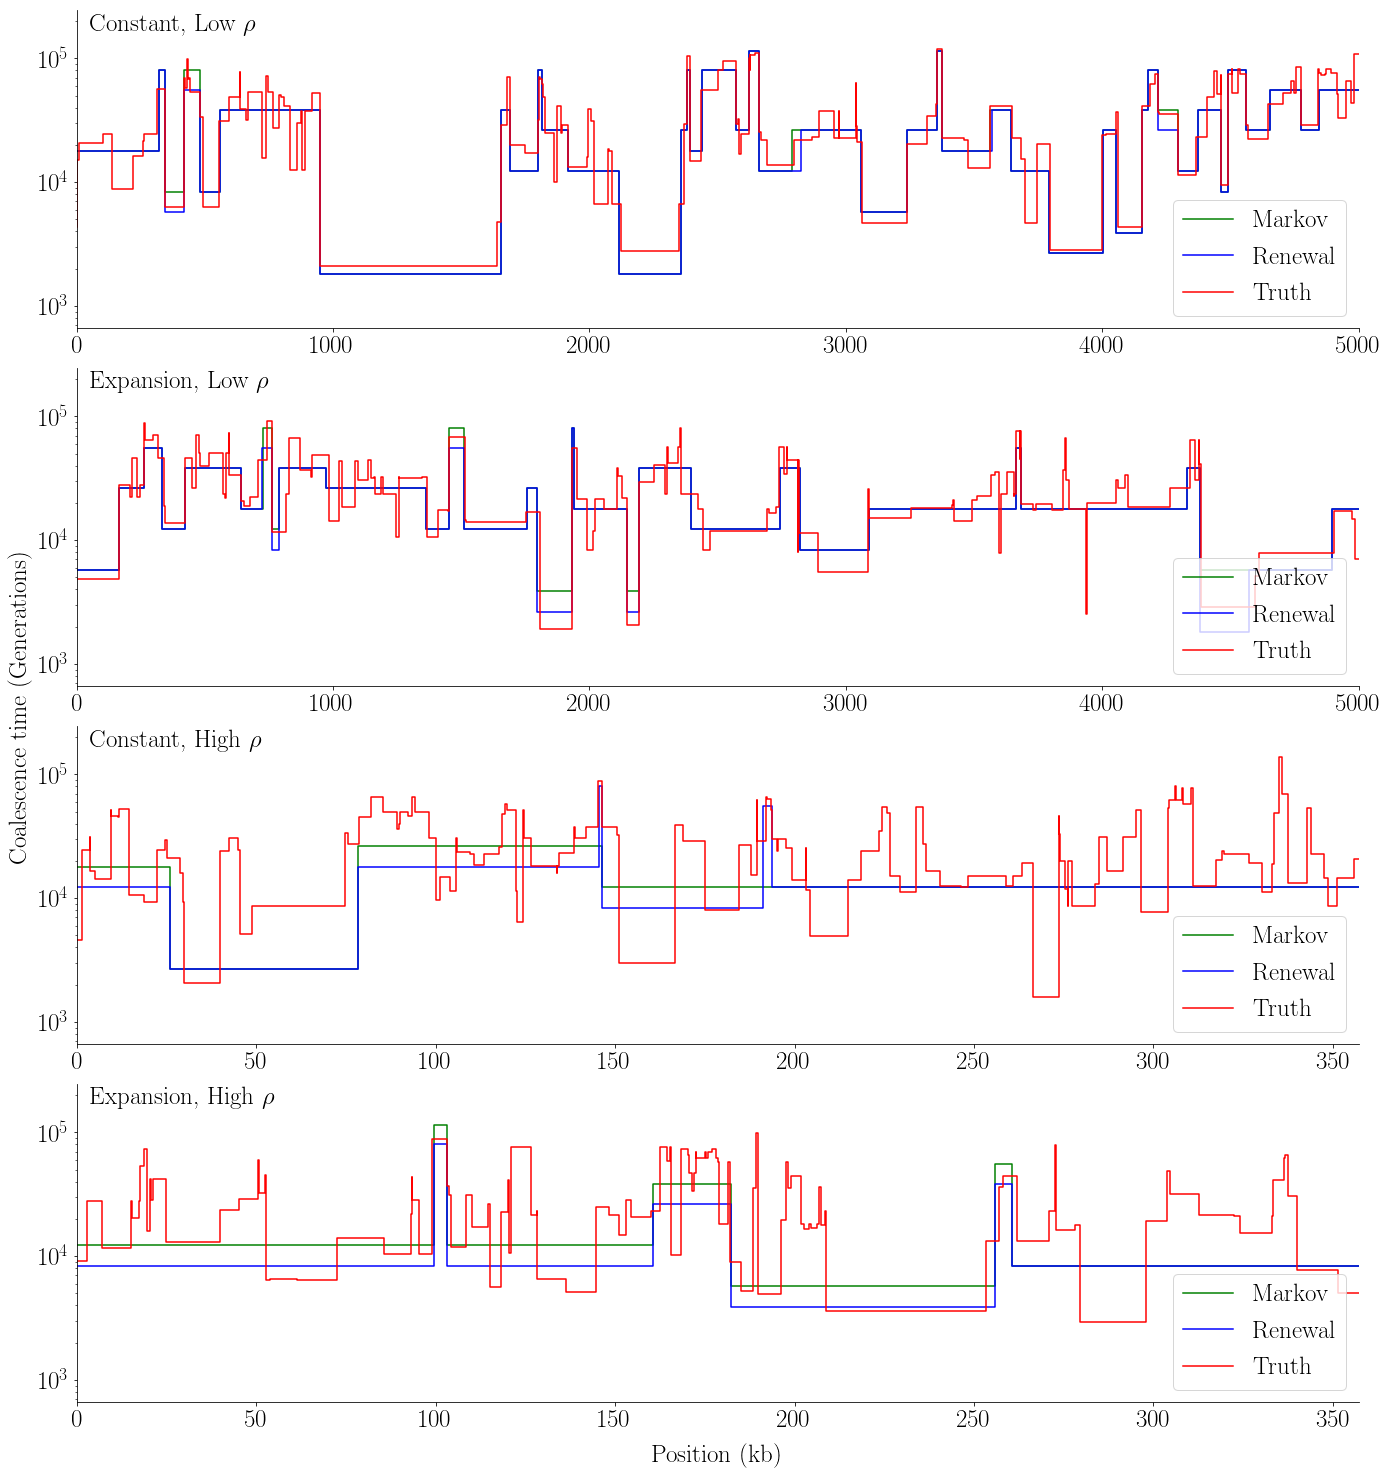

In [22]:
plot_seed = 6
ects= [ect_constant, ect_variable] * 2
ratio = 1e-9/1.4e-8
plot_viterbi(viterbis_Markov, viterbis_Renewal, tss, plot_seed, ects, L, w, ratio, 'viterbi1.pdf')

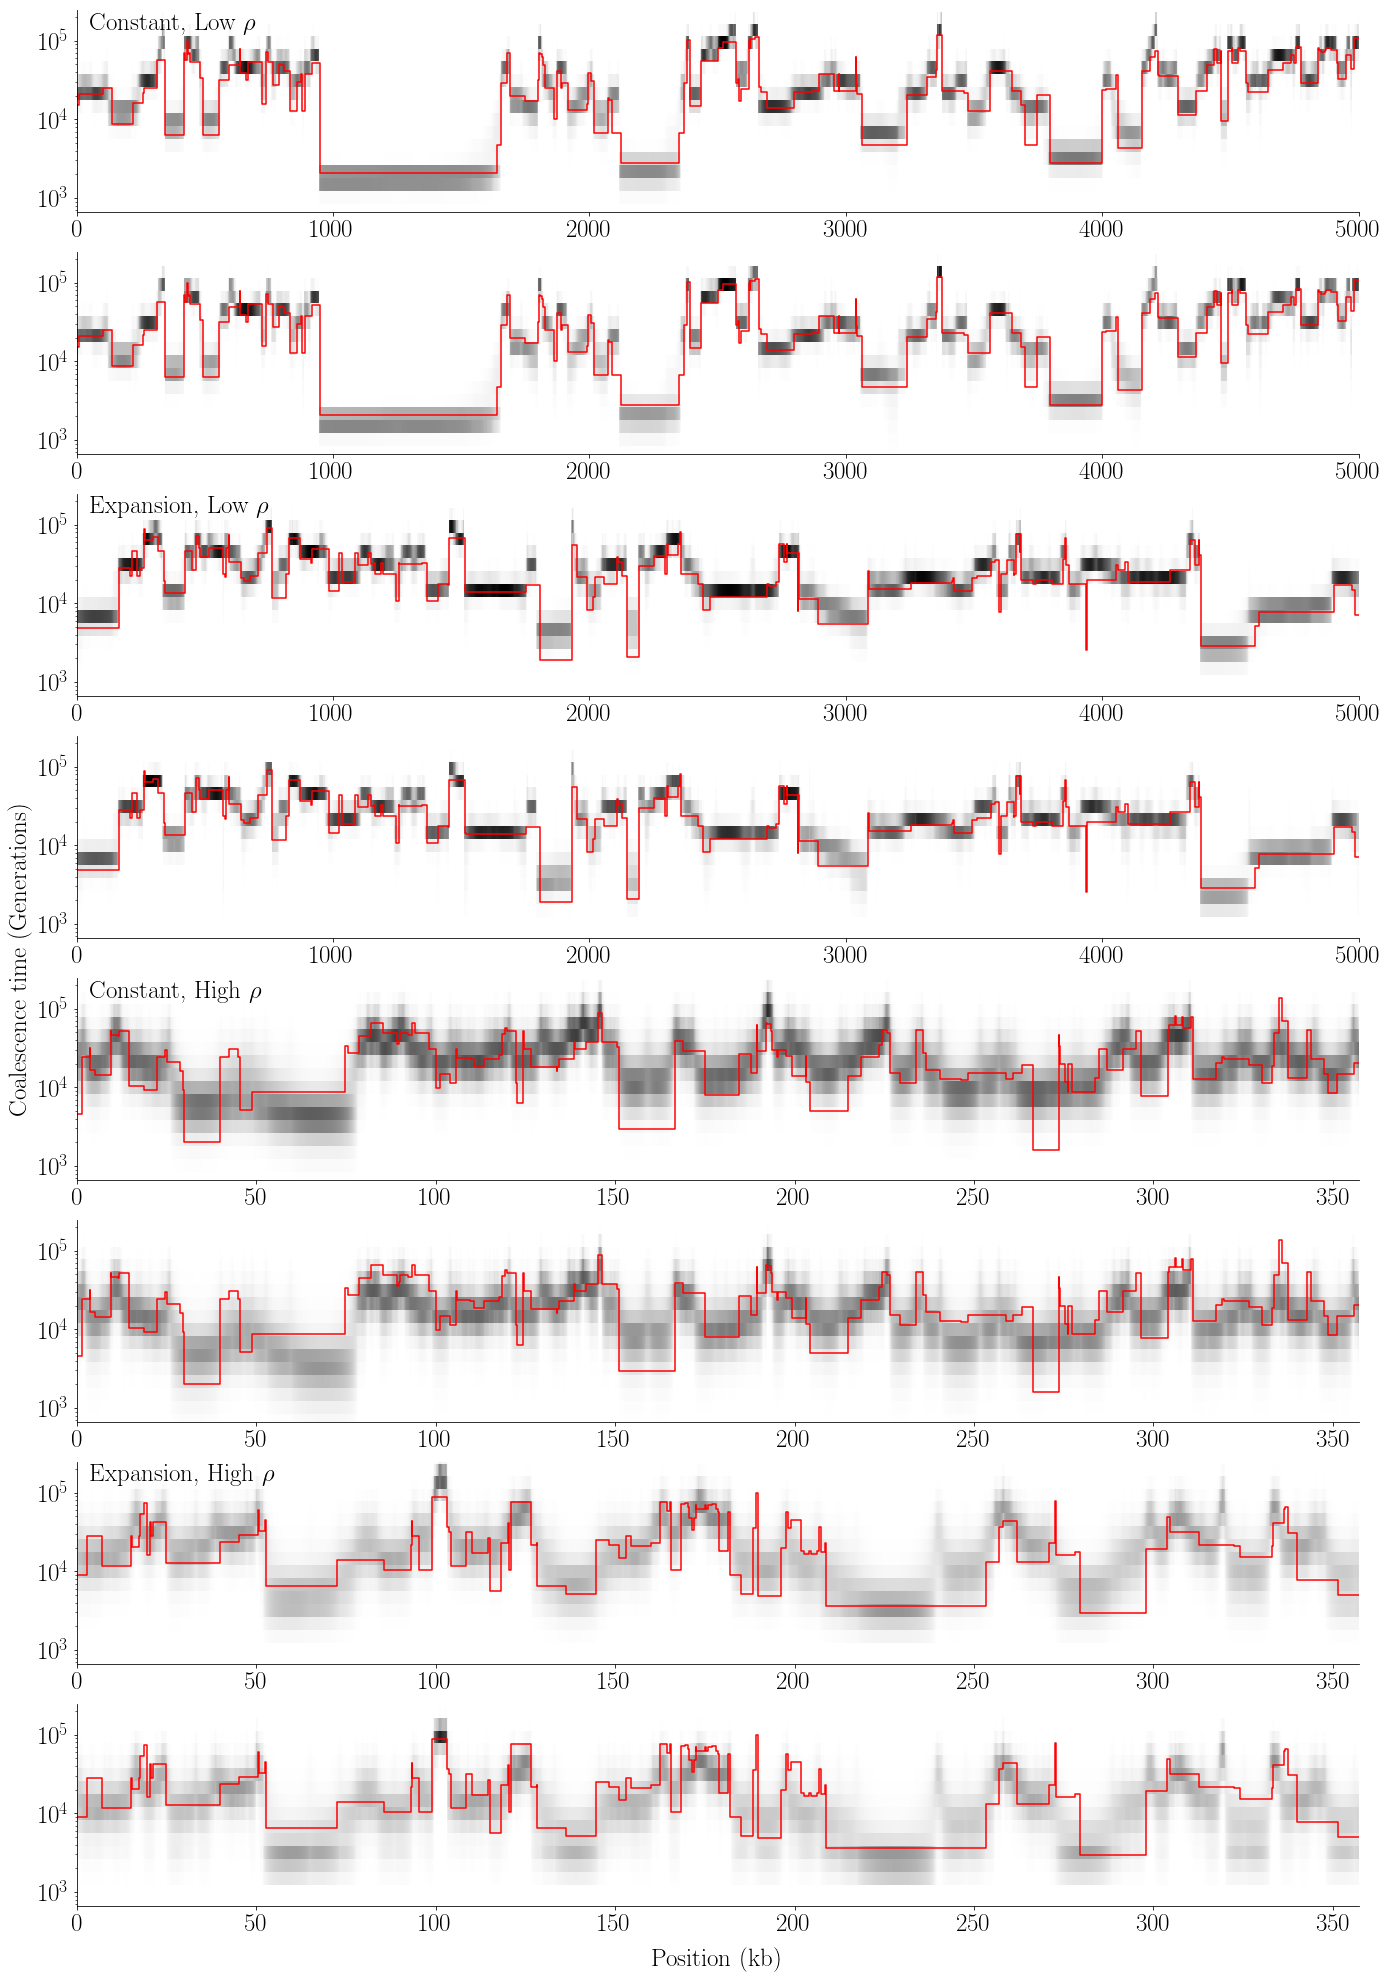

In [23]:
plot_posterior(gammas_Markov, gammas_Renewal, tss, plot_seed, ects, L, w, ratio, 'posterior1.pdf')

#### Creating tables

In [24]:
columns = ['Markov', 'Renewal']
df_abs = pd.DataFrame(columns=columns)
df_log = pd.DataFrame(columns=columns)

for i in range(4):
    tmrca, truth = get_truth(tss[i], w, times)

    if i%2==0:
        dist_abs = np.abs(ect_constant - tmrca[:,:,None])
        dist_log = np.abs(np.log10(ect_constant) - np.log10(tmrca[:,:,None]))
    else:
        dist_abs = np.abs(ect_variable - tmrca[:,:,None])
        dist_log = np.abs(np.log10(ect_variable) - np.log10(tmrca[:,:,None]))

    mean1, se1 = get_mean_se(gammas_Markov[i], dist_abs, L // w)
    mean2, se2 = get_mean_se(gammas_Renewal[i], dist_abs, L // w)
    mean3, se3 = get_mean_se(gammas_Markov[i], dist_log, L // w)
    mean4, se4 = get_mean_se(gammas_Renewal[i], dist_log, L // w)

    df_abs.loc[i] = [f'{mean1:.2f} ({se1:.2f})', f'{mean2:.2f} ({se2:.2f})']
    df_log.loc[i] = [f'{mean3:.4f} ({se3:.4f})', f'{mean4:.4f} ({se4:.4f})']

In [25]:
save_table(df_abs, 'table1_1.tex')

Scenario,1,2,3,4
Markov,6075.50 (215.59),5187.24 (187.27),12037.25 (298.71),12112.81 (106.44)
Renewal,6068.04 (209.11),5187.49 (184.34),11476.92 (282.36),11571.28 (97.99)


In [26]:
save_table(df_log, 'table1_2.tex')

Scenario,1,2,3,4
Markov,0.1362 (0.0035),0.1281 (0.0024),0.3051 (0.0013),0.3006 (0.0014)
Renewal,0.1437 (0.0026),0.1359 (0.0025),0.3451 (0.0046),0.3422 (0.0014)


In [27]:
columns = pd.MultiIndex.from_tuples([('Markov', 'Q1'), ('Renewal', 'Q1'), 
                                     ('Markov', 'Q2'), ('Renewal', 'Q2'),
                                     ('Markov', 'Q3'), ('Renewal', 'Q3'),
                                     ('Markov', 'Q4'), ('Renewal', 'Q4')])
df_abs = pd.DataFrame(columns=columns)
df_log = pd.DataFrame(columns=columns)

count = np.empty((4, 4, num_sim))

def get_row(l1, dec_places):
    mean = np.average(l1, axis=0)
    se = sem(l1, axis=0)
    row = [f'{m:.{dec_places}f} ({s:.{dec_places}f})' for m, s in zip(mean, se)]
    return row                       
                                  

for i in range(4):
    df_abs.loc[i] = [None] * 8
    df_log.loc[i] = [None] * 8
    tmrca, truth = get_truth(tss[i], w, times)
    l11 = np.empty((num_sim, 4))
    l12 = np.empty((num_sim, 4))
    l13 = np.empty((num_sim, 4))
    l14 = np.empty((num_sim, 4))
    
    if i%2==0:
        dist_abs = np.abs(ect_constant - tmrca[:,:,None])
        dist_log = np.abs(np.log10(ect_constant) - np.log10(tmrca[:,:,None]))
    else:
        dist_abs = np.abs(ect_variable - tmrca[:,:,None])
        dist_log = np.abs(np.log10(ect_variable) - np.log10(tmrca[:,:,None]))
            
    
    for j in range(num_sim):
        full_Markov_abs = gammas_Markov[i][j] * dist_abs[j]
        full_Renewal_abs = gammas_Renewal[i][j] * dist_abs[j]
        full_Markov_log = gammas_Markov[i][j] * dist_log[j]
        full_Renewal_log = gammas_Renewal[i][j] * dist_log[j]

        uniq_t = np.unique(tmrca)
        breaks = np.quantile(uniq_t, [0, 0.25, 0.5, 0.75])
        
        for k in range(4):
            if k != 3:
                inds_k = (tmrca[j] >= breaks[k]) & (tmrca[j] < breaks[k+1])
            else:
                inds_k = (tmrca[j] >= breaks[3])
                
            num_pos = inds_k.sum()
            count[i,k,j] = num_pos
            l11[j,k] = full_Markov_abs[inds_k].sum() / num_pos
            l12[j,k] = full_Renewal_abs[inds_k].sum() / num_pos
            l13[j,k] = full_Markov_log[inds_k].sum() / num_pos
            l14[j,k] = full_Renewal_log[inds_k].sum() / num_pos

    df_abs.loc[i][::2] = get_row(l11, 2)
    df_abs.loc[i][1::2] = get_row(l12, 2)
    df_log.loc[i][::2] = get_row(l13, 4)
    df_log.loc[i][1::2] = get_row(l14, 4)

In [28]:
mean = np.average(count, axis=2)
se = sem(count, axis=2)
entries = mfunc(mean, se, 2)
df = pd.DataFrame(data=entries, columns=['Q1', 'Q2', 'Q3', 'Q4'])
df['Scenario'] = ['1', '2', '3', '4']
df = df.set_index('Scenario').T
df.to_latex(folder + 'locicounts.tex')
display(df)

Scenario,1,2,3,4
Q1,25878.20 (951.37),28103.76 (1075.15),27807.96 (580.26),27659.64 (233.24)
Q2,12037.56 (646.81),10589.40 (702.38),10931.92 (331.94),11149.32 (143.83)
Q3,7917.24 (461.61),7231.24 (509.98),7200.76 (178.59),7119.12 (95.21)
Q4,4167.00 (360.71),4075.60 (272.09),4059.36 (124.89),4071.92 (90.72)


In [29]:
save_table(df_abs, 'table1_3.tex')

,Scenario,1,2,3,4
Markov,Q1,2840.79 (124.42),2219.61 (101.38),6820.01 (245.65),6672.23 (88.84)
Renewal,Q1,2887.14 (129.53),2273.91 (100.00),5292.75 (180.86),5256.89 (55.12)
Markov,Q2,6524.06 (131.61),6106.74 (122.89),13346.56 (35.50),13465.23 (57.68)
Renewal,Q2,6604.09 (117.57),6123.72 (107.90),11463.27 (38.05),11665.01 (35.60)
Markov,Q3,10543.82 (239.47),9716.04 (219.67),18831.10 (64.05),18957.97 (67.16)
Renewal,Q3,10454.31 (249.99),9528.27 (225.84),19538.07 (72.65),19682.76 (71.76)
Markov,Q4,17242.02 (460.92),16362.35 (471.86),33016.17 (212.12),33526.33 (226.10)
Renewal,Q4,16959.09 (505.93),16341.50 (601.40),40181.58 (263.39),40141.12 (279.70)


In [30]:
save_table(df_log, 'table1_4.tex')

,Scenario,1,2,3,4
Markov,Q1,0.1479 (0.0056),0.1328 (0.0033),0.3212 (0.0020),0.3080 (0.0022)
Renewal,Q1,0.1563 (0.0045),0.1413 (0.0034),0.3299 (0.0057),0.3119 (0.0018)
Markov,Q2,0.1279 (0.0023),0.1253 (0.0023),0.2755 (0.0016),0.2863 (0.0016)
Renewal,Q2,0.1373 (0.0024),0.1336 (0.0024),0.3277 (0.0019),0.3480 (0.0022)
Markov,Q3,0.1255 (0.0029),0.1242 (0.0036),0.2826 (0.0020),0.2857 (0.0022)
Renewal,Q3,0.1324 (0.0033),0.1293 (0.0039),0.3769 (0.0024),0.3857 (0.0024)
Markov,Q4,0.1197 (0.0036),0.1216 (0.0032),0.3168 (0.0026),0.3178 (0.0021)
Renewal,Q4,0.1247 (0.0040),0.1278 (0.0036),0.4546 (0.0029),0.4568 (0.0023)


### Simulation 2: Effect of Demographic Prior

#### Redefine some functions for second simulation

In [38]:
def plot_viterbi(viterbis, tss, ects, L_w, w, name):
    size = 25
    scale_to_kb = 1000 / w
    width = 3600
    
    fig, axs = plt.subplots(3, figsize=(20, 13.5), sharex=True, sharey=True)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    labels = ['Africa', 'Zigzag', 'Constant']    
    colors = ['purple', 'green', 'orange']
    
    for i, ax in enumerate(axs):
        ts = tss[i]
        for j in range(3):
            ect = ects[j]
        
            pmap = viterbis[i,j]
            dpmap, = np.diff(pmap).nonzero()
            x = np.r_[0, dpmap, L_w-1]
            y = ect[pmap[x]]
            ax.plot(x / scale_to_kb, y, drawstyle="steps-pre", color=colors[j], label=labels[j])

        truth = [(tree.interval[0] / w, tree.get_tmrca(0, 1)) for tree in ts.trees()]
        x, y = zip(*truth)
        x = np.r_[x, L_w]
        y = np.r_[y, y[-1]]
        ax.plot(x / scale_to_kb, y, drawstyle="steps-post", color="red", label='Truth')
        
        ax.set_yscale("log")
        ax.xaxis.set_tick_params(labelsize=size)
        ax.yaxis.set_tick_params(labelsize=size)
        ax.legend(loc = 'lower right', prop={'size': size})
        
        ax.text(0.01, .99, labels[i], transform=ax.transAxes,
                fontsize=size, va='top')
            
        sns.despine()
        
        if i == 0:
            ymin = np.amin(y[:width])
            ymax = np.amax(y[:width])
        
        else:
            ylow = np.amin(y[:width])
            if ylow < ymin:
                ymin = ylow
            
            yhigh = np.amax(y[:width])
            if yhigh > ymax:
                ymax = yhigh
    
    plt.setp(ax.get_xticklabels(), fontsize=size)   
    plt.setp(ax.get_yticklabels(), fontsize=size)
    plt.setp(ax, xlim=(0, width/scale_to_kb))
    plt.setp(ax, ylim=(0.75 * ymin, 1.25 * ymax))
    
    plt.xlabel('Position (kb)', fontsize=size, labelpad = size)
    plt.ylabel('Coalescence time (Generations)', fontsize=size, labelpad = size)
    plt.tight_layout()
    plt.savefig(folder + name, bbox_inches='tight')
    plt.show()

In [31]:
def plot_posterior(gammas, tss, ects, L_w, w, name):
    size = 25
    scale_to_kb = 1000 / w
    width = 3600
    
    fig, axs = plt.subplots(9, figsize=(20, 27), sharex=True, sharey=True)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    labels = ['Africa', 'Zigzag', 'Constant'] 
    
    for i, ax in enumerate(axs):
        ind1 = i//3
        ts = tss[ind1]
        
        ind2 = i % 3
        if ind2 == 0:
            ax.text(0.01, .99, labels[ind1], transform=ax.transAxes,
                fontsize=size, va='top')

        ect = ects[ind2]
        gamma = gammas[ind1,ind2,:width]
        
        truth = [(tree.interval[0] / w, tree.get_tmrca(0, 1)) for tree in ts.trees()]
        x, y = zip(*truth)
        x = np.r_[x, L_w]
        y = np.r_[y, y[-1]]
        ax.plot(x / scale_to_kb, y, drawstyle="steps-post", color="red", label='Truth')
        
        X, Y = np.meshgrid(np.arange(width), ect)
        im = ax.pcolormesh(X / scale_to_kb, Y, gamma.T, cmap="Greys", rasterized=True)
#         if unique_clim:
#             im.set_clim(np.amin(gamma), np.amax(gamma))
        
        ax.set_yscale("log")
        ax.xaxis.set_tick_params(labelsize=size)
        ax.yaxis.set_tick_params(labelsize=size)
        
        sns.despine()
        
        if i == 0:
            ymin = np.amin(y)
            ymax = np.amax(y)
        
        else:
            ylow = np.amin(y)
            if ylow < ymin:
                ymin = ylow
            
            yhigh = np.amax(y)
            if yhigh > ymax:
                ymax = yhigh
    
    plt.setp(ax.get_xticklabels(), fontsize=size)
    plt.setp(ax.get_yticklabels(), fontsize=size)
    plt.setp(ax, ylim=(0.75 * ymin, 1.25 * ymax))
    plt.setp(ax.set_xlim(0, width/scale_to_kb))
    
    plt.xlabel('Position (kb)', fontsize=size, labelpad = size)
    plt.ylabel('Coalescence time (Generations)', fontsize=size, labelpad = size)
    plt.tight_layout()
    plt.savefig(folder + name, bbox_inches='tight')
    plt.show()

In [106]:
def get_truth(ts, w, times):
    T = times.size
    L = tss[0].sequence_length
    L_w = int(np.ceil(L / w))
    tmrca = np.empty(L_w)
    
    cts = [(round(tree.interval[0] / w), 
            round(tree.interval[1] / w), 
            tree.get_tmrca(0,1)) for tree in ts.trees()]
    x1, x2, y = zip(*cts)
    for j in range(len(cts)):
        left = x1[j]
        right = x2[j]
        t = y[j]
        tmrca[left:right] = t
    return tmrca, truth

def create_table(err, name, log=False):
    columns = ['Africa', 'Zigzag', 'Constant']
    mean = np.average(err, axis=2)
    se = sem(err, axis=2)
    if log:
        dec_places = 4
    else:
        dec_places = 2
    entries = mfunc(mean, se, dec_places)
    df = pd.DataFrame(data=entries, index=columns, columns=columns)
    df.to_latex(folder + name)
    display(df)

#### Set simulation and model parameters

In [95]:
num_sim = 25
w = 100

species = stdpopsim.get_species("HomSap")
chrom = 22
contig = species.get_contig(f'chr{chrom}')
r = contig.recombination_map.get_rates()[0]
mu = contig.mutation_rate

T = 64
times = np.r_[0.0, np.geomspace(1e1, 1e6, T-1)]

plot_seed = 1

In [96]:
africa = species.get_demographic_model("Africa_1T12")
zigzag = species.get_demographic_model("Zigzag_1S14")
constant = stdpopsim.PiecewiseConstantSize(species.population_size)
models = [africa, zigzag, constant]

demo_africa = africa.get_demography_debugger()
demo_zigzag = zigzag.get_demography_debugger()

eta_africa = np.squeeze(1/(2*demo_africa.population_size_trajectory(steps=times)))
eta_zigzag = np.squeeze(1/(2*demo_zigzag.population_size_trajectory(steps=times)))
eta_constant = np.repeat(1/(2*species.population_size), T)
etas = [eta_africa, eta_zigzag, eta_constant]

L = species.genome.chromosomes[chrom-1].length
L_w = int(np.ceil(L / w))

w_end = None
if L % w > 0:
    w_end = L % w
rho = 2*r*w

#### Population size trajectories 

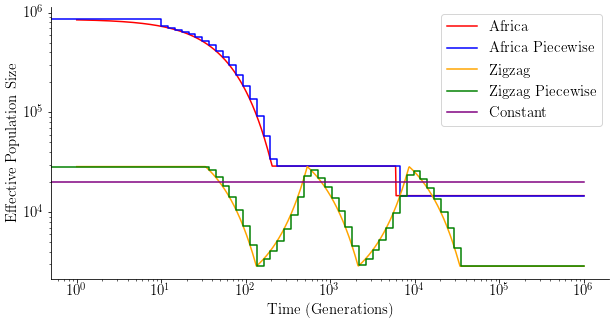

In [115]:
plt.figure(figsize=(10,5))

x = np.geomspace(1, 1e6, 1000)
y = np.squeeze(2*demo_africa.population_size_trajectory(steps=x))
plt.plot(x, y, color='red', label='Africa')

y = np.squeeze(2*demo_africa.population_size_trajectory(steps=times))
plt.plot(times, y, color="blue", drawstyle='steps-post', label='Africa Piecewise')

x = np.geomspace(1, 1e6, 1000)
y = np.squeeze(2*demo_zigzag.population_size_trajectory(steps=x))
plt.plot(x, y, color='orange', label='Zigzag')

y = np.squeeze(2*demo_zigzag.population_size_trajectory(steps=times))
plt.plot(times, y, color="green", drawstyle='steps-post', label='Zigzag Piecewise')

plt.plot([0,1e6], [2*species.population_size]*2, color='purple', label='Constant')

size = 15
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)

plt.xlabel('Time (Generations)', fontsize=size)
plt.ylabel('Effective Population Size', fontsize=size)
sns.despine()

plt.legend(fontsize=size)
plt.yscale('log')
plt.xscale('log')
plt.savefig(folder + 'sizehistory.pdf')

#### Run simulations

In [98]:
ids = [None] * 3
ects = [None] * 3
transitions = [None] * 3

gammas = np.empty((3,3,L_w,T))
viterbis = np.empty((3,3,L_w), dtype=int)
tss = []

engine = stdpopsim.get_engine('msprime')

err_A = np.empty((3, 3, num_sim))
err_B = np.empty((3, 3, num_sim))

for j in range(3):
    ids[j] = initial_distribution(times, etas[j])
    ects[j] = get_expected_coal_times(times, etas[j])
    transitions[j] = get_transitions_Renewal(times, ects[j], rho, etas[j])

for i in range(3):
    model = models[i]
    samples = model.get_samples(2)
    for k in range(num_sim):
        print(i, k)
        ts = engine.simulate(model, contig, samples, seed=k+1)
        if k+1 == plot_seed:
            tss.append(ts)
        
        tmrca, truth = get_truth(ts, w, times)           

        for j in range(3):
            emissions = get_emissions(ts, w, L_w, mu, ects[j], w_end)
            gamma = get_posterior(L_w, T, ids[j], emissions, transitions[j])
            dist_abs = np.abs(ects[j] - tmrca[:,None])
            dist_log = np.abs(np.log10(ects[j]) - np.log10(tmrca[:,None]))
            err_A[i,j,k] = (gamma * dist_abs).sum()/L_w
            err_B[i,j,k] = (gamma * dist_log).sum()/L_w

            if k+1 == plot_seed:
                gammas[i,j] = gamma
                viterbis[i,j] = get_viterbi(np.log(transitions[j]), np.log(emissions), np.log(ids[j]), L_w)

0 0


/home/caleb/Desktop/Git/HMM-EM/venv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24


#### Plot results

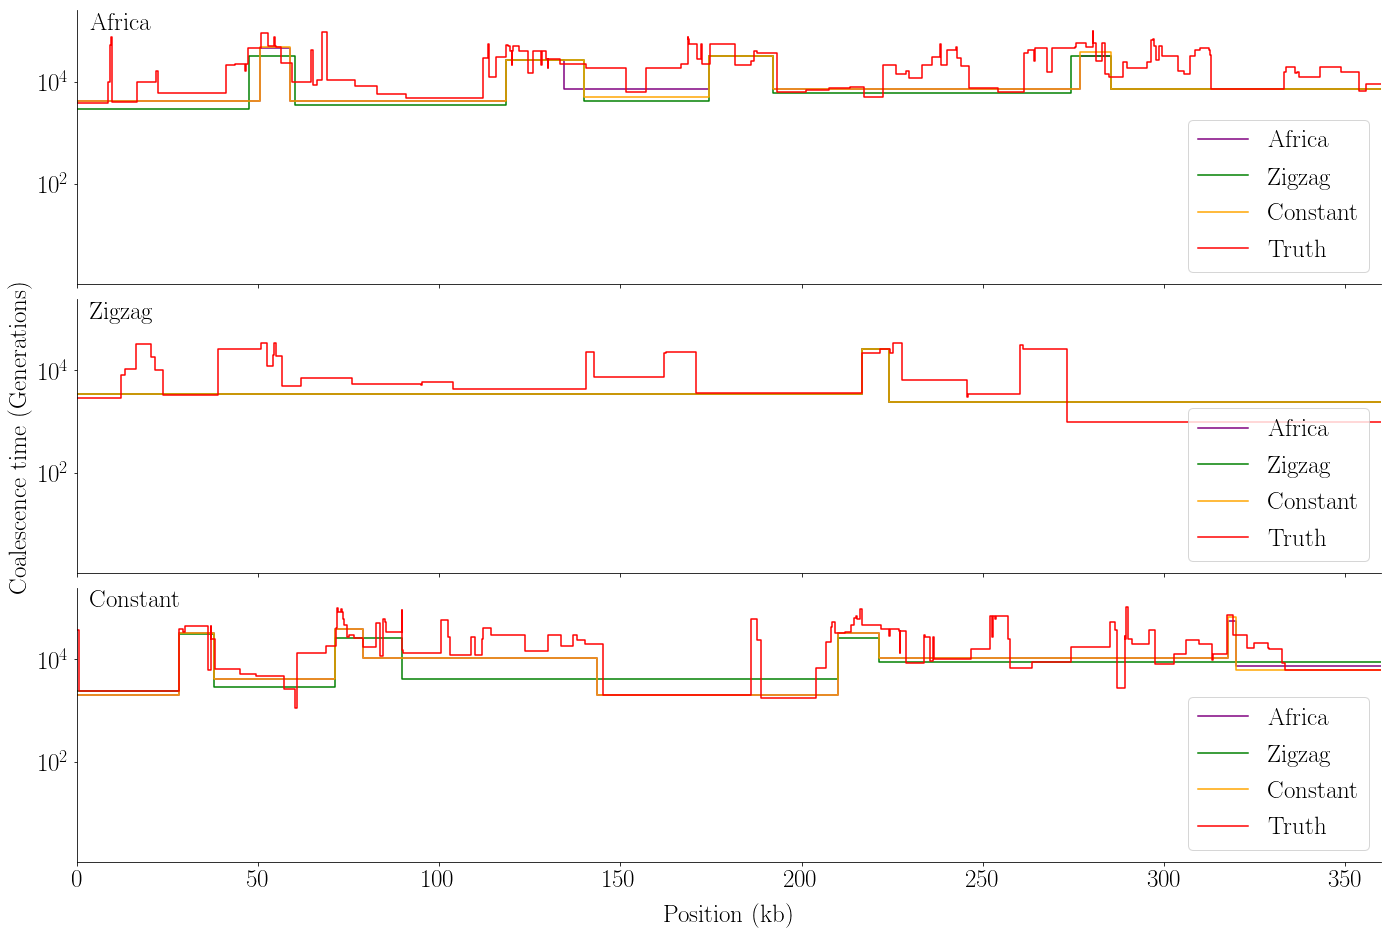

In [111]:
plot_viterbi(viterbis, tss, ects, L_w, w, 'viterbi2.pdf')

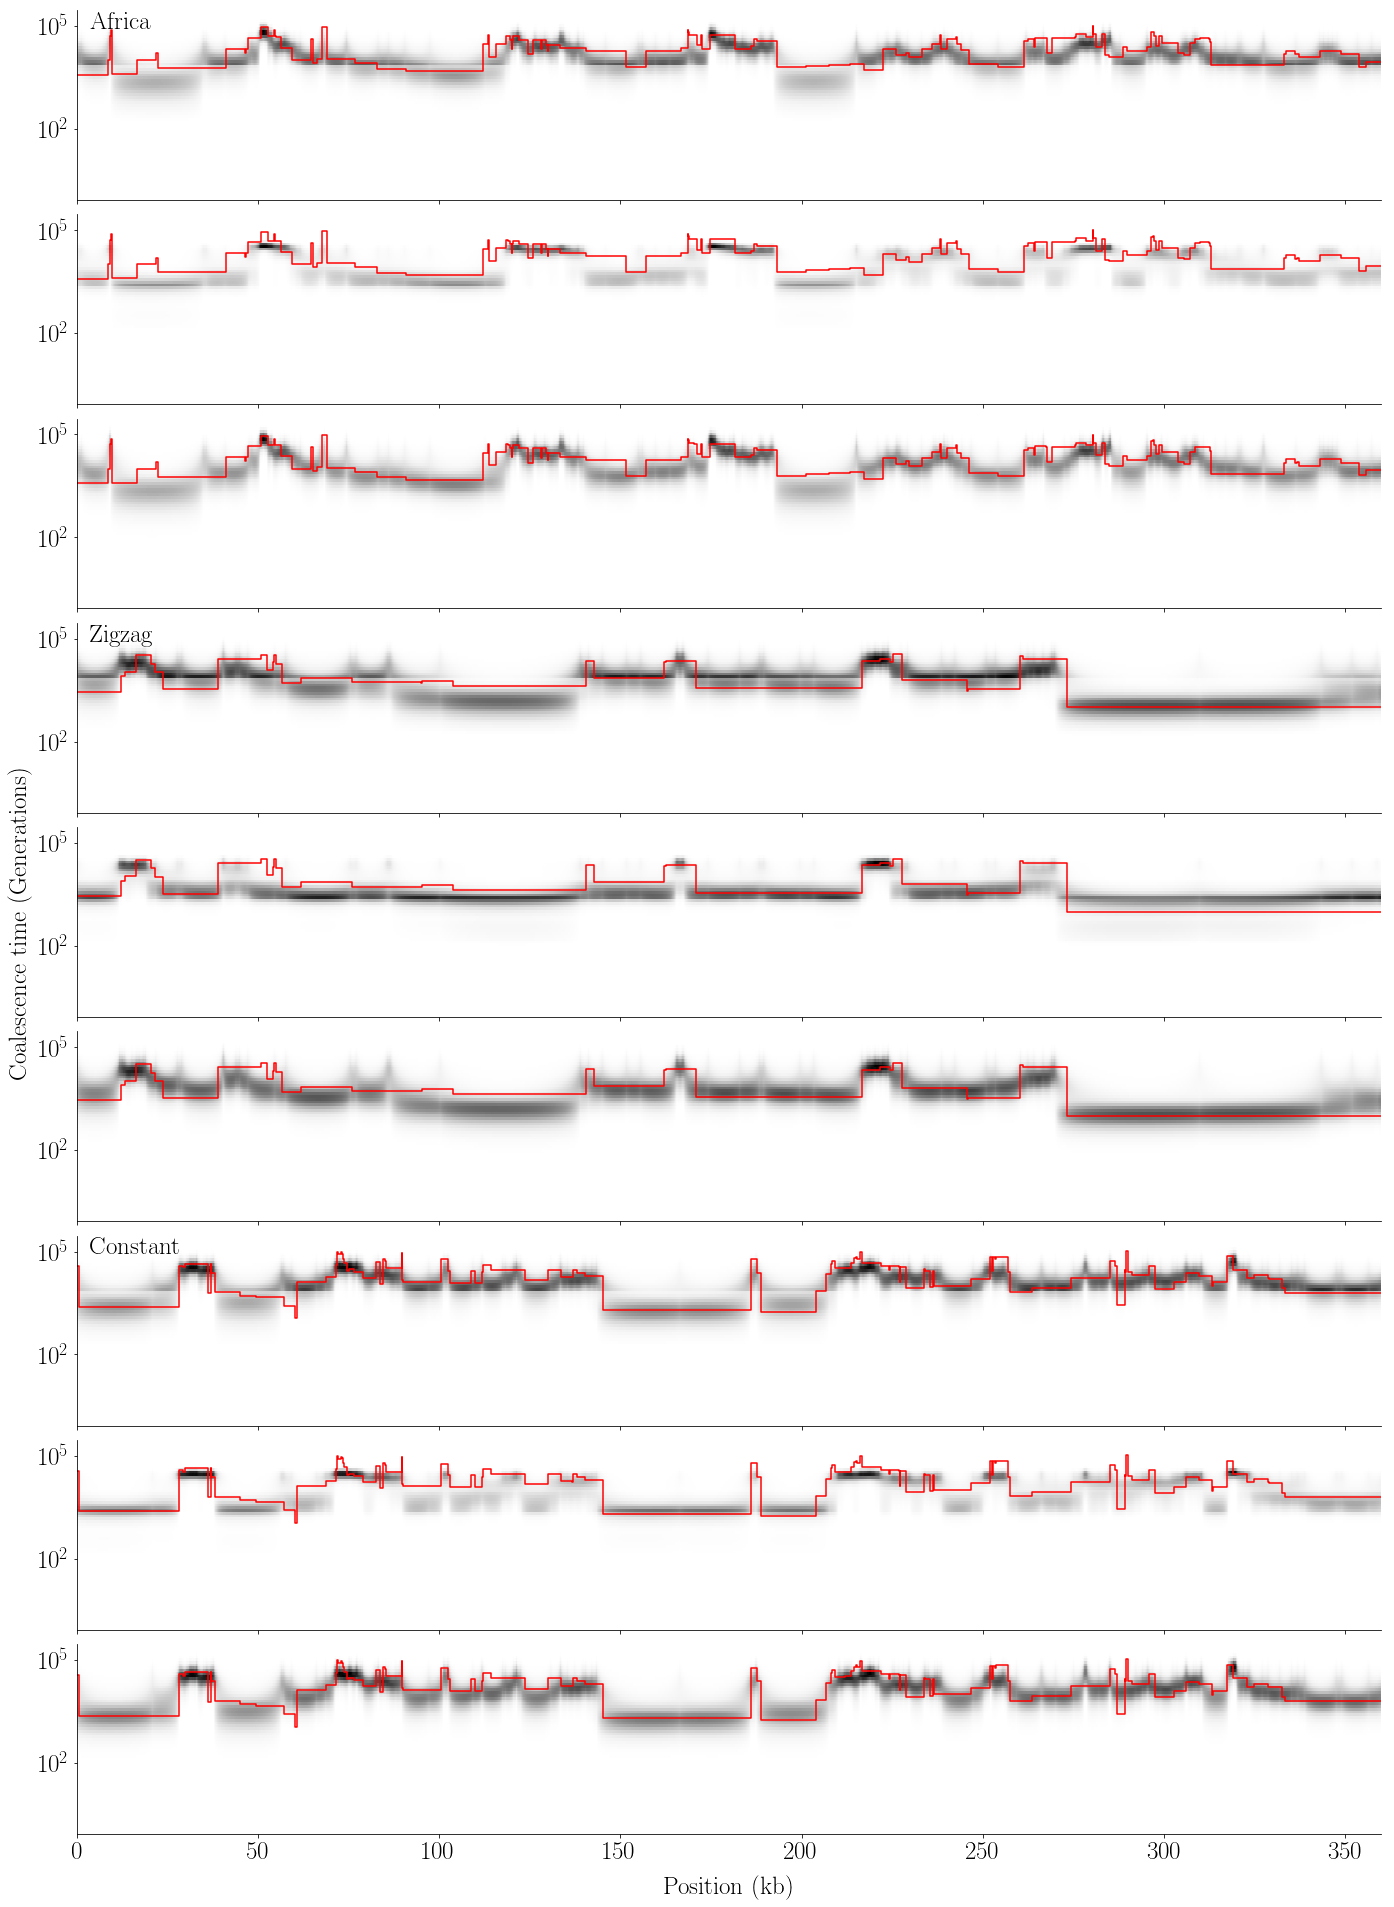

In [112]:
plot_posterior(gammas, tss, ects, L_w, w, 'posterior2.pdf')

In [113]:
create_table(err_A, 'table2_1.tex')

,Africa,Zigzag,Constant
Africa,10144.40 (19.76),10359.75 (20.84),10663.13 (20.19)
Zigzag,5507.79 (132.03),4962.75 (120.63),5700.60 (137.21)
Constant,11584.24 (259.28),11764.86 (263.18),11898.49 (266.09)


In [114]:
create_table(err_B, 'table2_2.tex', log=True)

,Africa,Zigzag,Constant
Africa,0.3293 (0.0004),0.3934 (0.0005),0.3549 (0.0004)
Zigzag,0.3678 (0.0041),0.3548 (0.0042),0.3788 (0.0038)
Constant,0.3496 (0.0068),0.3955 (0.0059),0.3679 (0.0064)
